In [1]:
import json
import torch
import time
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

#### Load Bilinear Loading Dataset (https://zenodo.org/records/7915753) :

##### Split Dataset into train and test beforehand for being in the same page with TensorFlow trainings:

In [2]:
all_features = np.load("Bilinear_Loading_Dataset/Features.npy")
all_neck = np.load("Bilinear_Loading_Dataset/Necks.npy")
print(all_neck.shape)

#split
X_train, X_test, y_train, y_test = train_test_split(all_features, all_neck, test_size=0.15, random_state=42)

def convert(X):
    return 1 - np.exp(-X)

def convert_inverse(K):
    return -np.log(1-K)

normalized_y_train = convert(y_train)
normalized_y_test = convert(y_test)

np.save("Train_features.npy", X_train)
np.save("Train_necks.npy", normalized_y_train)
np.save("Test_features.npy", X_test)
np.save("Test_necks.npy", normalized_y_test)

(19098, 401)


In [3]:
class BilinearDataset(torch.utils.data.Dataset):

    def __init__(self, feature_root, neck_root):
        
        self.features = np.load(feature_root) 
        self.necks = np.load(neck_root)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        
        feature = self.features[idx]
        neck = self.necks[idx]
        
        feature = torch.as_tensor(feature, dtype = torch.float ) 
        neck = torch.as_tensor(neck, dtype = torch.float)
        
        feature = feature.to(device)
        neck = neck.to(device)
        
        return feature, neck

In [4]:
train_dataset = BilinearDataset(feature_root = "Train_features.npy", neck_root = "Train_necks.npy")
test_dataset = BilinearDataset(feature_root = "Test_features.npy", neck_root = "Test_necks.npy")

In [5]:
Train_Data = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)
Test_Data = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)

#### Convolutional Blocks :

In [6]:
class CNN_block(nn.Module):
    def __init__(self, embed_dim, hid_dim, kernel_size, num_layers):
        super(CNN_block, self).__init__()
        
        self.embed_dim = embed_dim
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.embed_hidden = nn.Linear(embed_dim, hid_dim)
        self.tanh = torch.nn.Tanh()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, out_channels = 2 * hid_dim, kernel_size = kernel_size, padding = 'same') for _ in range(num_layers)])
        self.glu = torch.nn.GLU(dim = 1)
        self.hidden_embed = nn.Linear(hid_dim, embed_dim)
        
    def forward(self, inputs):
        
        conv_input = self.embed_hidden(inputs)
        
        conv_input = self.tanh(conv_input)
        
        conv_input = conv_input.permute(0, 2, 1)
        
        for i, conv in enumerate(self.convs):
            
            #pass through convolutional layer
            conved = conv(conv_input)
            
            #pass through tanh activation function
            conved = self.tanh(conved)
        
            #pass through GLU activation function
            conved = self.glu(conved)
            
            #apply residual connection
            conved = conved + conv_input
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hidden_embed(conv_input.permute(0, 2, 1))
        
        output = conved + inputs
        
        return output

In [7]:
class Build_Model(nn.Module):
    
    def __init__(self, num_blocks, number_of_layers):
        super(Build_Model, self).__init__()
        
        self.num_blocks = num_blocks
        
        self.number_of_layers = number_of_layers
        
        self.conv_blocks = nn.ModuleList([CNN_block(embed_dim = 3, hid_dim = 3, kernel_size = 6, num_layers = number_of_layers) for _ in range(num_blocks)])
        
        self.out = nn.Linear(3,1)
        
        self.Activation = nn.Sigmoid()
        
        self.Flatten = nn.Flatten()
        
    def forward(self, inputs):
        
        for i, conv_block in enumerate(self.conv_blocks):
            
            conved_block = conv_block(inputs)
            
            inputs = conved_block
            
        conved_block = self.out(inputs)
        
        conved_block = self.Activation(conved_block)
        
        conved_flatten = self.Flatten(conved_block)
        
        return conved_flatten

#### Training codes :

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_loss = 0.0
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]"
    
     #print("Train loss :", train_loss)
            
def test_loop(dataloader, model, loss_fn):
    test_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        test_loss = test_loss + loss.item()

In [9]:
def Calc_MSE(model, data_loader):

    M = []

    L = []

    for batch, (X,y) in enumerate(data_loader):
    
        Pred = model.forward(X)
    
        Pred_np = Pred.detach().cpu().numpy()
    
        y = y.detach().cpu().numpy()
    
        for i in range(len(Pred_np)):
        
            M.append(convert_inverse(Pred_np[i]).tolist())
        
            L.append(convert_inverse(y[i]).tolist())
    
    #K.append(convert_inverse(Pred_np).tolist())
    
    result = mean_squared_error(np.array(M),np.array(L))
    
    return result

In [10]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [11]:
# Number of blocks 1-5
# Number of layers 1-80

NB = [i for i in range(1,6)]
NL = [i for i in range(1,81,2)]

In [12]:
Training_Results = []

C = 0

for num_blocks in NB:
    
    for num_layers in NL:
        
        MODEL = Build_Model(num_blocks = num_blocks, number_of_layers = num_layers)
        
        number_of_parameters = get_n_params(MODEL)
        
        MODEL = MODEL.to(device)
        
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
            
            # Define Hyperparameters :

            learning_rate = 0.001
            #weight_decay = 0.0001
            #batch_size = 32
            num_epochs = 100
            
            
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.AdamW(params = MODEL.parameters(), lr = learning_rate)
            
            ## Training Loop:
            
            epochs = 100
            for t in range(epochs):
                #print(f"Epoch {t+1}\n-------------------------------")
                train_loop(Train_Data, MODEL, loss_fn, optimizer)
                test_loop(Test_Data, MODEL, loss_fn)
                #print("Done!")
                
            end = time.time()
            
            ## Testing MSEs :
            
            mse_train = Calc_MSE(MODEL, Train_Data)
            mse_test = Calc_MSE(MODEL, Test_Data)
            
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [num_layers, num_blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))
                                    

C:\Users\muyatk\.conda\envs\tf-gpu\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


 1 -- Train results, Train mse : 0.012038 Test mse: 0.011621, number of parameters : 142, time passed : 208.695885
 2 -- Train results, Train mse : 0.008579 Test mse: 0.008356, number of parameters : 370, time passed : 224.424871
 3 -- Train results, Train mse : 0.008694 Test mse: 0.008427, number of parameters : 598, time passed : 240.124769
 4 -- Train results, Train mse : 0.008846 Test mse: 0.008482, number of parameters : 826, time passed : 258.482401
 5 -- Train results, Train mse : 0.006925 Test mse: 0.006612, number of parameters : 1054, time passed : 276.670600
 6 -- Train results, Train mse : 0.006363 Test mse: 0.006014, number of parameters : 1282, time passed : 288.723082
 7 -- Train results, Train mse : 0.006801 Test mse: 0.006396, number of parameters : 1510, time passed : 305.719683
 8 -- Train results, Train mse : 0.005955 Test mse: 0.005674, number of parameters : 1738, time passed : 322.932359
 9 -- Train results, Train mse : 0.005985 Test mse: 0.005693, number of para

 72 -- Train results, Train mse : 0.004901 Test mse: 0.004636, number of parameters : 6574, time passed : 658.628534
 73 -- Train results, Train mse : 0.004538 Test mse: 0.004347, number of parameters : 7258, time passed : 701.607520
 74 -- Train results, Train mse : 0.004542 Test mse: 0.004237, number of parameters : 7942, time passed : 745.972341
 75 -- Train results, Train mse : 0.004397 Test mse: 0.004201, number of parameters : 8626, time passed : 794.637183
 76 -- Train results, Train mse : 0.004339 Test mse: 0.004079, number of parameters : 9310, time passed : 836.406473
 77 -- Train results, Train mse : 0.004729 Test mse: 0.004510, number of parameters : 9994, time passed : 879.987209
 78 -- Train results, Train mse : 0.006990 Test mse: 0.006558, number of parameters : 556, time passed : 277.124997
 79 -- Train results, Train mse : 0.006693 Test mse: 0.006452, number of parameters : 1468, time passed : 340.030955
 80 -- Train results, Train mse : 0.005103 Test mse: 0.004780, nu

In [13]:
with open("CNN_RNN_Transformers_Training_Results/CNN_blocks_0_10000_PyTorch.json", 'w') as f:
    json.dump(Training_Results, f)

In [14]:
f = open("CNN_RNN_Transformers_Training_Results/CNN_blocks_0_10000_PyTorch.json")
data = json.load(f)

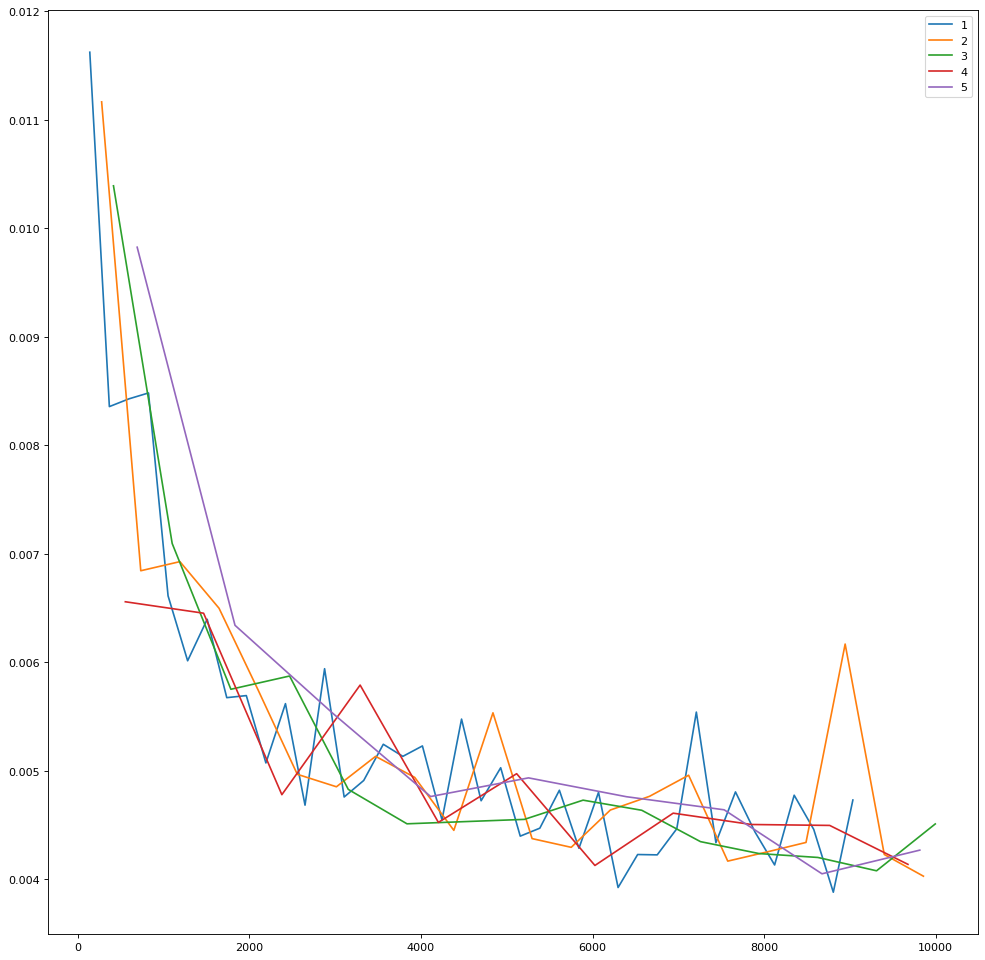

In [15]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()

### RNN :

#### LSTM Blocks :

In [16]:
class RNN_block(nn.Module):
    def __init__(self, units = 32, feature_dim = 3):
        super().__init__()

        self.lstm_1 = nn.LSTM(feature_dim, units, 1, batch_first=True, bias=True)
        self.lstm_2 = nn.LSTM(units, units, 1, batch_first=True, bias = True)

    def forward(self, inputs):

        lstm_1_output, (state_h_1, state_c_1) = self.lstm_1(inputs)

        encoder_state = (state_h_1, state_c_1)

        output, (state_h_2, state_c_2) = self.lstm_2(lstm_1_output, encoder_state)

        return output

In [17]:
class Build_Model(nn.Module):
    
    def __init__(self, num_blocks, units):
        super(Build_Model, self).__init__()
        
        self.num_blocks = num_blocks
        
        self.units = units
        
        self.first_rnn_block = RNN_block(units = units)
        
        self.rnn_blocks = nn.ModuleList([RNN_block(feature_dim = units, units = units) for _ in range(num_blocks-1)])
        
        self.rnn_block_out = RNN_block(1, feature_dim = units)
        
        self.Flatten = nn.Flatten()
        
    def forward(self, inputs):
        
        out = self.first_rnn_block(inputs)
        
        for i, rnn_block in enumerate(self.rnn_blocks):
            
            rnn_block = rnn_block(out)
            
            out = rnn_block
        
        rnn_block = self.rnn_block_out(out)
        
        rnn_flatten = self.Flatten(rnn_block)
        
        return rnn_flatten

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_loss = 0.0
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
    
def test_loop(dataloader, model, loss_fn):
    test_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        test_loss = test_loss + loss.item()
    

In [19]:
# Number of blocks 1-5
# Number of units 1-29

NB = [i for i in range(1,6)]
NU = [i for i in range(1,29,1)]

In [20]:
Training_Results = []

C = 0

for num_blocks in NB:
    
    for units in NU:
        
        MODEL = Build_Model(num_blocks = num_blocks, units = units)
        
        number_of_parameters = get_n_params(MODEL)
        
        MODEL = MODEL.to(device)
        
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
            
            # Define Hyperparameters :

            learning_rate = 0.001
            num_epochs = 100
            
            
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.AdamW(params = MODEL.parameters(), lr = learning_rate)
            
            ## Training Loop:
            
            epochs = 100
            for t in range(epochs):
                #print(f"Epoch {t+1}\n-------------------------------")
                train_loop(Train_Data, MODEL, loss_fn, optimizer)
                test_loop(Test_Data, MODEL, loss_fn)
                #print("Done!")
                
            end = time.time()
            
            ## Testing MSEs :
            
            mse_train = Calc_MSE(MODEL, Train_Data)
            mse_test = Calc_MSE(MODEL, Test_Data)
            
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [units, num_blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))
                                    

 1 -- Train results, Train mse : 0.016772 Test mse: 0.016797, number of parameters : 72, time passed : 455.439934
 2 -- Train results, Train mse : 0.012245 Test mse: 0.011955, number of parameters : 140, time passed : 472.380687
 3 -- Train results, Train mse : 0.006295 Test mse: 0.005942, number of parameters : 232, time passed : 474.222164
 4 -- Train results, Train mse : 0.006768 Test mse: 0.006436, number of parameters : 348, time passed : 479.903508
 5 -- Train results, Train mse : 0.007260 Test mse: 0.007072, number of parameters : 488, time passed : 482.859323
 6 -- Train results, Train mse : 0.005243 Test mse: 0.005107, number of parameters : 652, time passed : 481.887949
 7 -- Train results, Train mse : 0.004871 Test mse: 0.004611, number of parameters : 840, time passed : 486.533812
 8 -- Train results, Train mse : 0.003979 Test mse: 0.003900, number of parameters : 1052, time passed : 468.151397
 9 -- Train results, Train mse : 0.004108 Test mse: 0.003937, number of paramete

 72 -- Train results, Train mse : 0.029657 Test mse: 0.029663, number of parameters : 200, time passed : 632.803126
 73 -- Train results, Train mse : 0.015144 Test mse: 0.014948, number of parameters : 524, time passed : 662.548409
 74 -- Train results, Train mse : 0.005589 Test mse: 0.005537, number of parameters : 1000, time passed : 665.725101
 75 -- Train results, Train mse : 0.005396 Test mse: 0.005283, number of parameters : 1628, time passed : 670.897949
 76 -- Train results, Train mse : 0.004161 Test mse: 0.003992, number of parameters : 2408, time passed : 659.645022
 77 -- Train results, Train mse : 0.004381 Test mse: 0.004199, number of parameters : 3340, time passed : 656.945445
 78 -- Train results, Train mse : 0.001951 Test mse: 0.001905, number of parameters : 4424, time passed : 658.532228
 79 -- Train results, Train mse : 0.002924 Test mse: 0.002739, number of parameters : 5660, time passed : 637.228096
 80 -- Train results, Train mse : 0.002095 Test mse: 0.001924, num

In [21]:
with open("CNN_RNN_Transformers_Training_Results/LSTM_blocks_0_10000_PyTorch.json", 'w') as f:
    json.dump(Training_Results, f)

In [22]:
f = open("CNN_RNN_Transformers_Training_Results/LSTM_blocks_0_10000_PyTorch.json")
data = json.load(f)

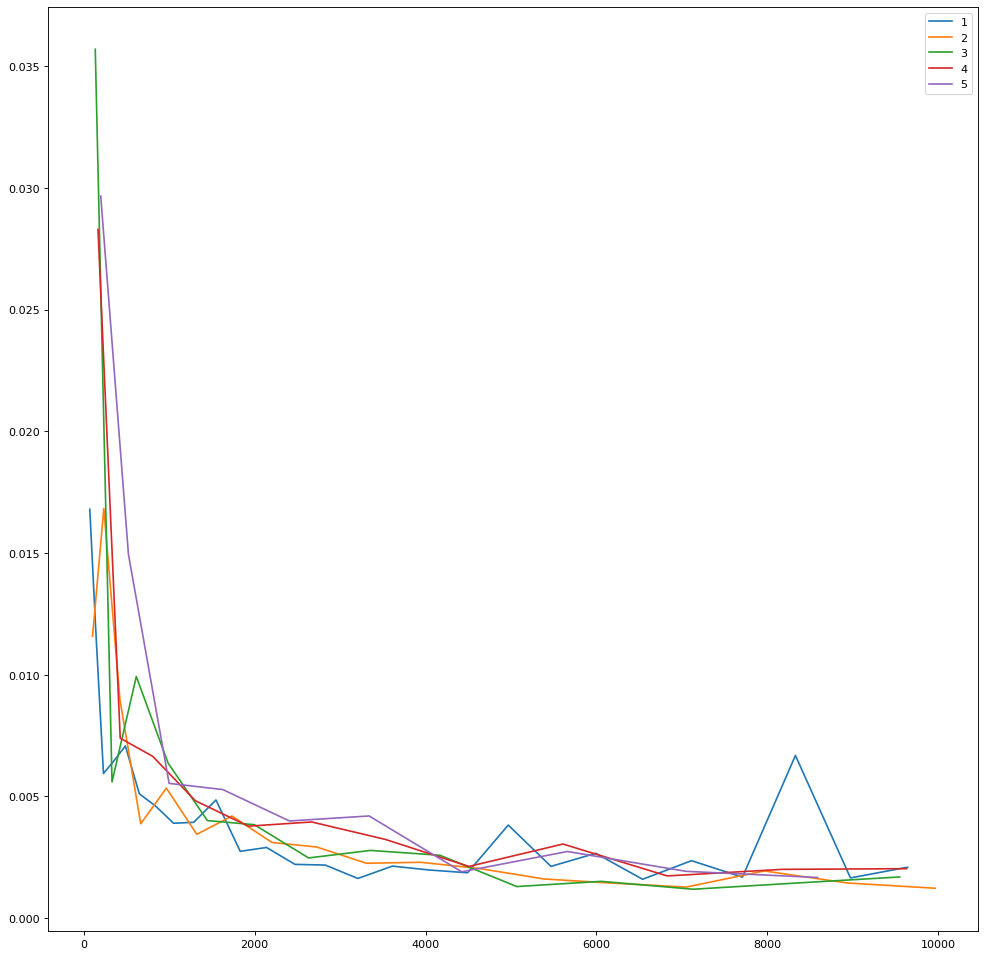

In [23]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()

#### GRU Blocks :

In [24]:
class RNN_block(nn.Module):
    def __init__(self, units = 32, feature_dim = 3):
        super().__init__()

        self.gru_1 = nn.GRU(feature_dim, units, 1, batch_first=True, bias=True)
        self.gru_2 = nn.GRU(units, units, 1, batch_first=True, bias = True)

    def forward(self, inputs):

        gru_1_output, encoder_state = self.gru_1(inputs)

        output, encoder_state = self.gru_2(gru_1_output, encoder_state)

        return output

In [25]:
class Build_Model(nn.Module):
    
    def __init__(self, num_blocks, units):
        super(Build_Model, self).__init__()
        
        self.num_blocks = num_blocks
        
        self.units = units
        
        self.first_rnn_block = RNN_block(units = units)
        
        self.rnn_blocks = nn.ModuleList([RNN_block(feature_dim = units, units = units) for _ in range(num_blocks-1)])
        
        self.rnn_block_out = RNN_block(1, feature_dim = units)
        
        self.Flatten = nn.Flatten()
        
    def forward(self, inputs):
        
        out = self.first_rnn_block(inputs)
        
        for i, rnn_block in enumerate(self.rnn_blocks):
            
            rnn_block = rnn_block(out)
            
            out = rnn_block
        
        rnn_block = self.rnn_block_out(out)
        
        rnn_flatten = self.Flatten(rnn_block)
        
        return rnn_flatten

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_loss = 0.0
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
    
def test_loop(dataloader, model, loss_fn):
    test_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        test_loss = test_loss + loss.item()
    

In [27]:
# Number of blocks 1-5
# Number of units 1-29

NB = [i for i in range(1,6)]
NU = [i for i in range(1,29,1)]

In [28]:
Training_Results = []

C = 0

for num_blocks in NB:
    
    for units in NU:
        
        MODEL = Build_Model(num_blocks = num_blocks, units = units)
        
        number_of_parameters = get_n_params(MODEL)
        
        MODEL = MODEL.to(device)
        
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
            
            # Define Hyperparameters :

            learning_rate = 0.001
            num_epochs = 100
            
            
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.AdamW(params = MODEL.parameters(), lr = learning_rate)
            
            ## Training Loop:
            
            epochs = 100
            for t in range(epochs):
                #print(f"Epoch {t+1}\n-------------------------------")
                train_loop(Train_Data, MODEL, loss_fn, optimizer)
                test_loop(Test_Data, MODEL, loss_fn)
                #print("Done!")
                
            end = time.time()
            
            ## Testing MSEs :
            
            mse_train = Calc_MSE(MODEL, Train_Data)
            mse_test = Calc_MSE(MODEL, Test_Data)
            
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [units, num_blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))
                                    

 1 -- Train results, Train mse : 0.011158 Test mse: 0.010817, number of parameters : 54, time passed : 415.617723
 2 -- Train results, Train mse : 0.013100 Test mse: 0.012983, number of parameters : 105, time passed : 429.194892
 3 -- Train results, Train mse : 0.006662 Test mse: 0.006622, number of parameters : 174, time passed : 432.856823
 4 -- Train results, Train mse : 0.004552 Test mse: 0.004444, number of parameters : 261, time passed : 435.576849
 5 -- Train results, Train mse : 0.003042 Test mse: 0.002897, number of parameters : 366, time passed : 439.518315
 6 -- Train results, Train mse : 0.002541 Test mse: 0.002408, number of parameters : 489, time passed : 442.624356
 7 -- Train results, Train mse : 0.003092 Test mse: 0.002838, number of parameters : 630, time passed : 444.582873
 8 -- Train results, Train mse : 0.003547 Test mse: 0.003403, number of parameters : 789, time passed : 439.248660
 9 -- Train results, Train mse : 0.003371 Test mse: 0.003279, number of parameter

 72 -- Train results, Train mse : 0.001122 Test mse: 0.001145, number of parameters : 3381, time passed : 601.947067
 73 -- Train results, Train mse : 0.001157 Test mse: 0.001193, number of parameters : 4206, time passed : 621.828682
 74 -- Train results, Train mse : 0.001917 Test mse: 0.001813, number of parameters : 5121, time passed : 620.785008
 75 -- Train results, Train mse : 0.001721 Test mse: 0.001732, number of parameters : 6126, time passed : 621.756794
 76 -- Train results, Train mse : 0.001798 Test mse: 0.001718, number of parameters : 7221, time passed : 613.730314
 77 -- Train results, Train mse : 0.001174 Test mse: 0.001156, number of parameters : 8406, time passed : 627.711785
 78 -- Train results, Train mse : 0.001146 Test mse: 0.001123, number of parameters : 9681, time passed : 629.335352
 79 -- Train results, Train mse : 0.025754 Test mse: 0.025812, number of parameters : 150, time passed : 675.944238
 80 -- Train results, Train mse : 0.004042 Test mse: 0.003976, nu

In [29]:
with open("CNN_RNN_Transformers_Training_Results/GRU_blocks_0_10000_PyTorch.json", 'w') as f:
    json.dump(Training_Results, f)

In [30]:
f = open("CNN_RNN_Transformers_Training_Results/GRU_blocks_0_10000_PyTorch.json")
data = json.load(f)

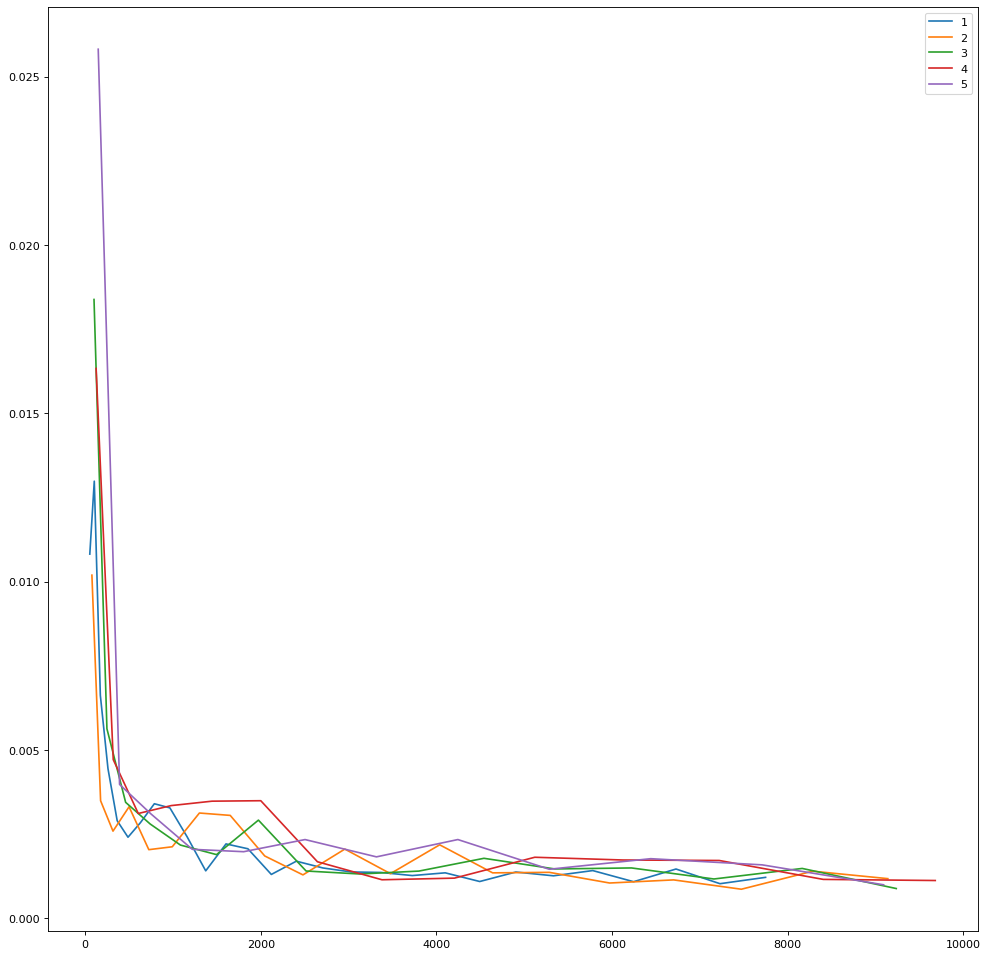

In [31]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()

### Transformer Blocks :

* Note : This implementation needs to be recheck again especially there can be differences between Multihead Attention layer between Keras and PyTorch

In [32]:
class TransformerBlock(nn.Module):
    def __init__(self, feature_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()

        self.projection_1 = nn.Linear(feature_dim, num_heads)
        self.attention = nn.MultiheadAttention(embed_dim = num_heads, num_heads = num_heads, batch_first=True)
        self.projection_2 = nn.Linear(num_heads, feature_dim)
        self.linear_1 = nn.Linear(feature_dim, ff_dim)
        self.tanh = nn.Tanh()
        self.linear_2 = nn.Linear(ff_dim, feature_dim)
        self.norm_1 = nn.LayerNorm(feature_dim, eps=1e-06)
        self.norm_2 = nn.LayerNorm(feature_dim, eps=1e-06)
        self.DropOut_1 = nn.Dropout(p = rate)
        self.DropOut_2 = nn.Dropout(p = rate)
        
    def forward(self, inputs):

        X = self.projection_1(inputs)
        attn_output, attn_output_weights = self.attention(X, X, X)
        attn_output = self.projection_2(attn_output)
        attn_output = self.DropOut_1(attn_output)

        out1 = self.norm_1(inputs + attn_output)
        ffn_output = self.linear_1(out1)
        ffn_output = self.tanh(ffn_output)
        ffn_output = self.linear_2(ffn_output)
        ffn_output = self.DropOut_2(ffn_output)

        return self.norm_2(out1 + ffn_output)
        

* Note : Again there can be still some implementational problems needs to be checked again

In [33]:
class Build_Model(nn.Module):
    
    def __init__(self, number_of_heads, feed_forward, number_of_blocks):
        super(Build_Model, self).__init__()
        
        self.transformer_blocks = nn.ModuleList([TransformerBlock(feature_dim = 3, num_heads = number_of_heads, ff_dim = feed_forward) for _ in range(number_of_blocks)])
        
        self.out = nn.Linear(3,1)
        
        self.Activation = nn.Sigmoid()
        
        self.Flatten = nn.Flatten()
        
    def forward(self, inputs):
        
        for i, transformer_block in enumerate(self.transformer_blocks):
            
            transformered_block = transformer_block(inputs)
            
            inputs = transformered_block
            
        transformered_block = self.out(inputs)
        
        transformered_block = self.Activation(transformered_block)
        
        transformed_flatten = self.Flatten(transformered_block)
        
        return transformed_flatten

In [34]:
# Number of blocks 1-5
# Number of heads 1-128

NH = [i+1 for i in range(1,129,2)] # Number of heads in each block
NB = [i+1 for i in range(6)]# Number of blocks

In [35]:
Training_Results = []

C = 0

for num_blocks in NB:
    
    for heads in NH:
        
        MODEL = Build_Model(number_of_heads = heads, feed_forward = 4, number_of_blocks = num_blocks)
        
        number_of_parameters = get_n_params(MODEL)
        
        MODEL = MODEL.to(device)
        
        K = {}

        if number_of_parameters<= 10000:
                
            start = time.time()
            
            # Define Hyperparameters :

            learning_rate = 0.001
            num_epochs = 100
            
            
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.AdamW(params = MODEL.parameters(), lr = learning_rate)
            
            ## Training Loop:
            
            epochs = 100
            for t in range(epochs):
                #print(f"Epoch {t+1}\n-------------------------------")
                train_loop(Train_Data, MODEL, loss_fn, optimizer)
                test_loop(Test_Data, MODEL, loss_fn)
                #print("Done!")
                
            end = time.time()
            
            ## Testing MSEs :
            
            mse_train = Calc_MSE(MODEL, Train_Data)
            mse_test = Calc_MSE(MODEL, Test_Data)
            
            K["mse_train"] = mse_train
            K["mse_test"] = mse_test
            K["parameter_values"] = [heads, num_blocks]
            K["number_of_parameters"] = number_of_parameters
            K["training_time"] = end - start
                
            Training_Results.append(K)
                
            C = C + 1
                
            print(" %d -- Train results, Train mse : %f Test mse: %f, number of parameters : %d, time passed : %f" %(C,mse_train, mse_test, number_of_parameters, end - start))
                                    

 1 -- Train results, Train mse : 0.028337 Test mse: 0.028140, number of parameters : 88, time passed : 276.839546
 2 -- Train results, Train mse : 0.022219 Test mse: 0.022183, number of parameters : 158, time passed : 321.112004
 3 -- Train results, Train mse : 0.017569 Test mse: 0.017297, number of parameters : 260, time passed : 369.581468
 4 -- Train results, Train mse : 0.018368 Test mse: 0.018124, number of parameters : 394, time passed : 418.666268
 5 -- Train results, Train mse : 0.014754 Test mse: 0.014454, number of parameters : 560, time passed : 468.334555
 6 -- Train results, Train mse : 0.013847 Test mse: 0.013771, number of parameters : 758, time passed : 517.905559
 7 -- Train results, Train mse : 0.013258 Test mse: 0.013006, number of parameters : 988, time passed : 567.965201
 8 -- Train results, Train mse : 0.012331 Test mse: 0.012081, number of parameters : 1250, time passed : 617.280597
 9 -- Train results, Train mse : 0.010945 Test mse: 0.010867, number of paramete

 71 -- Train results, Train mse : 0.008446 Test mse: 0.008252, number of parameters : 4924, time passed : 2093.843675
 72 -- Train results, Train mse : 0.008189 Test mse: 0.008202, number of parameters : 6234, time passed : 2341.043253
 73 -- Train results, Train mse : 0.007071 Test mse: 0.006944, number of parameters : 7704, time passed : 2648.897223
 74 -- Train results, Train mse : 0.013066 Test mse: 0.012987, number of parameters : 9334, time passed : 2964.041519
 75 -- Train results, Train mse : 0.016871 Test mse: 0.016563, number of parameters : 508, time passed : 698.390881
 76 -- Train results, Train mse : 0.013840 Test mse: 0.013614, number of parameters : 928, time passed : 993.506300
 77 -- Train results, Train mse : 0.011052 Test mse: 0.010617, number of parameters : 1540, time passed : 1289.897918
 78 -- Train results, Train mse : 0.010303 Test mse: 0.010038, number of parameters : 2344, time passed : 1580.967145
 79 -- Train results, Train mse : 0.008755 Test mse: 0.00871

In [36]:
with open("CNN_RNN_Transformers_Training_Results/Transformers_blocks_0_10000_PyTorch.json", 'w') as f:
    json.dump(Training_Results, f)

In [37]:
f = open("CNN_RNN_Transformers_Training_Results/Transformers_blocks_0_10000_PyTorch.json")
data = json.load(f)

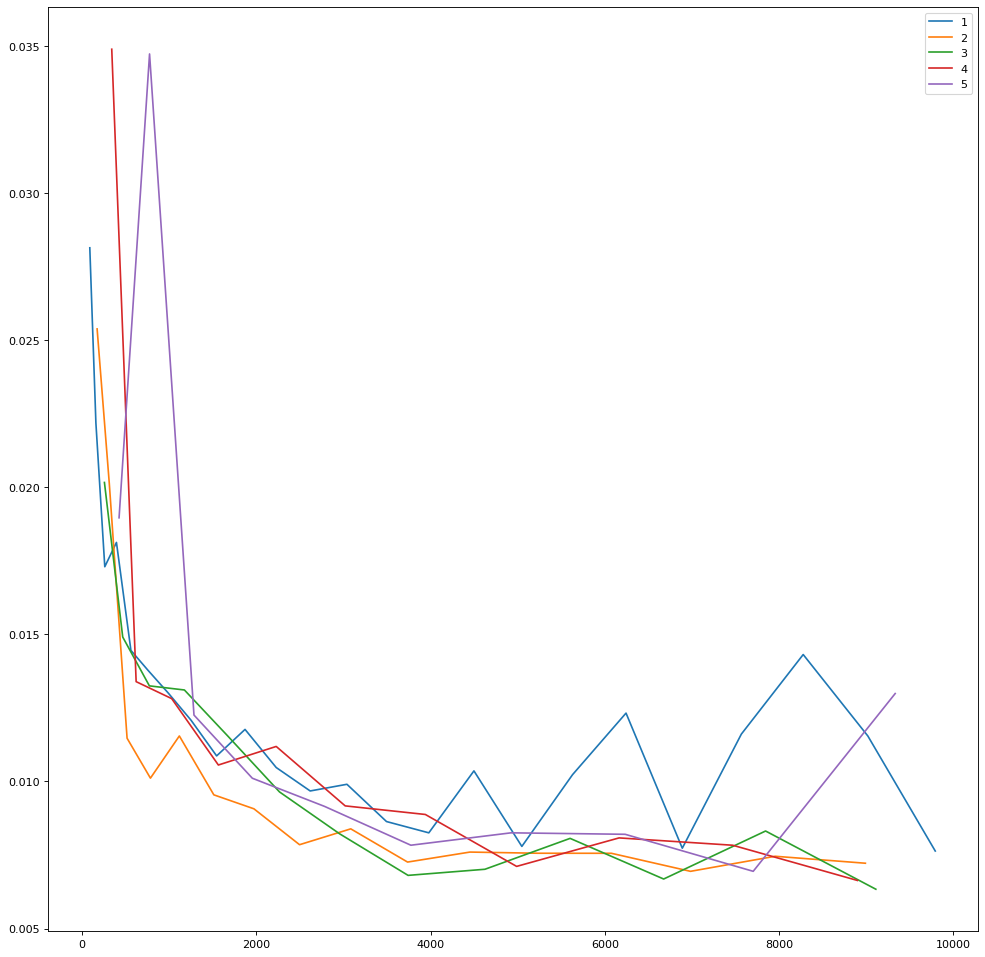

In [38]:
figure(figsize=(15, 15), dpi=80)

for j in range(1,6):         
        
    R = []

    N = []
        
    for i in range(len(data)):
        
        if data[i]["parameter_values"][1]==j:
            
            R.append(data[i]["mse_test"])
            
            N.append(data[i]["number_of_parameters"])
            
    plt.plot(N, R, label = str(j))
    
plt.legend()
plt.show()